### **Chapter 2: Use the FFT to up-sample an image: first double the size of the lena grayscale image by padding zero rows/columns at every alternate positions, then use the FFT followed by an LPF and then by the IFFT to get the output image. Why does it work?**

***
#### Mô tả bài toán:
1. Padding ảnh: Bắt đầu với tăng kích thước của ảnh bằng cách thêm các hàng và cột bằng 0 vào các vị trí xen kẽ. Bước này giúp tăng độ phân giải không gian của ảnh bằng cách thêm các giá trị 0 vào miền Fourier.
2. FFT: Tính toán FFT 2D (Biến đổi Fourier nhanh 2 chiều) của ảnh đã được padding. FFT chuyển đổi ảnh từ miền không gian sang miền tần số.
3. LPF: Sau khi thực hiện FFT, Áp dụng bộ lọc thông thấp (LPF) để loại bỏ các thành phần tần số cao có thể gây ra hiện tượng aliasing hoặc các artifact không mong muốn trong ảnh được tăng mẫu. Bộ lọc thông thấp này giúp làm mượt các thành phần tần số.
4. IFFT: Cuối cùng, Áp dụng biến đổi ngược FFT (IFFT) để chuyển đổi ảnh trở lại từ miền tần số về miền không gian, kết quả là ảnh đã được tăng mẫu.
#### 1. Import các thư viện cần thiết

In [2]:
# Import required libraries
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image 
from scipy.fft import fft2, ifft2, fftshift 

1. Thư viện NumPy cung cấp các hàm và công cụ mạnh mẽ để làm việc với các mảng và ma trận, đặc biệt hữu ích cho các phép toán số học và xử lý ảnh.
2. Matplotlib là một thư viện vẽ đồ họa trong Python. pyplot là một module trong Matplotlib dùng để tạo các biểu đồ và đồ thị, giúp hiển thị ảnh và kết quả của các phép toán.
3. PIL (Python Imaging Library) hoặc Pillow (một thư viện kế thừa từ PIL) cung cấp các công cụ để mở, xử lý và lưu trữ các tệp hình ảnh. Image là module của Pillow cho phép tải và thao tác với ảnh.
4. scipy.fft là một phần của thư viện SciPy hỗ trợ các phép toán Fourier.
    + fft2: Tính toán biến đổi Fourier 2D của ảnh (chuyển ảnh từ miền không gian sang miền tần số).
    + ifft2: Tính toán biến đổi ngược Fourier 2D (chuyển ảnh từ miền tần số về miền không gian).
    + fftshift: Dịch chuyển tần số về giữa ảnh sau khi tính toán FFT, giúp dễ dàng nhìn thấy các thành phần tần số thấp và cao.

#### 2. Mở ảnh, in thông tin và hiển thị ảnh gốc

<class 'PIL.Image.Image'> L 453 340


Text(0.5, 1.0, 'Original Image')

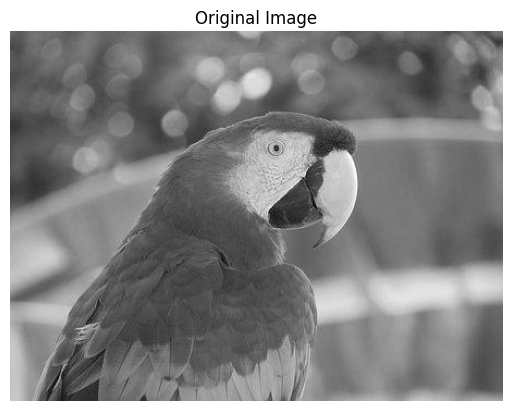

In [3]:
image = Image.open('parrot_gray.png').convert('L')
print(type(image), image.mode, image.width, image.height) 
image_np = np.array(image)

plt.subplot(1, 1, 1)
plt.imshow(image_np, cmap='gray')
plt.axis('off')
plt.title("Original Image")

1. Image.open('parrot_gray.png').convert('L'): 
    + Mở ảnh từ tệp 'parrot_gray.png' và chuyển đổi nó sang chế độ "L" (màu xám, grayscale). 
    + Điều này đảm bảo ảnh chỉ chứa các giá trị độ sáng (intensity) mà không có thông tin màu sắc.
2. print(type(image), image.mode, image.width, image.height): In ra thông tin về đối tượng image:
    + type(image): Kiểu của đối tượng.
    + image.mode: Chế độ ảnh (ở đây là "L" cho ảnh grayscale).
    + image.width và image.height: Chiều rộng và chiều cao của ảnh.
3. image_np = np.array(image): 
    + Chuyển đổi ảnh thành mảng NumPy, mỗi pixel trong ảnh sẽ trở thành một phần tử trong mảng 2D.
4. Hiển thị ảnh:
    + plt.subplot(1, 1, 1): Chỉ định rằng đang vẽ một đồ thị (subplot) duy nhất trong cửa sổ hiển thị với bố cục 1 x 1
    + plt.imshow(image_np, cmap='gray'): Hiển thị ảnh sử dụng imshow, với cmap='gray' để hiển thị ảnh ở chế độ màu xám.
    + plt.axis('off'): Tắt trục tọa độ để không hiển thị các giá trị trục x và y.
    + plt.title("Original Image"): Đặt tiêu đề cho ảnh là "Original Image".

#### 3. Xử lý ảnh theo các bước của bài toán

##### 3.1 Padding the image

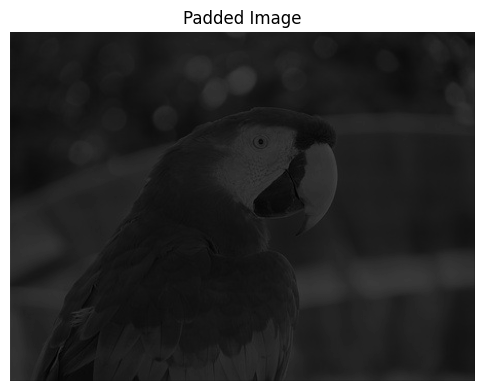

In [4]:
# Step 1: Padding the image
padded_image = np.zeros((image_np.shape[0] * 2, image_np.shape[1] * 2))
padded_image[::2, ::2] = image_np

plt.figure(figsize=(6, 6))
plt.imshow(padded_image, cmap='gray')
plt.title("Padded Image")
plt.axis('off')
plt.show()


+ padded_image = np.zeros((image_np.shape[0] * 2, image_np.shape[1] * 2)) : Tạo mảng padding
    + image_np.shape[0]: Chiều cao (số dòng) của ảnh gốc.
    + image_np.shape[1]: Chiều rộng (số cột) của ảnh gốc.
    + np.zeros((height, width)): Tạo một mảng NumPy có kích thước gấp đôi chiều cao và chiều rộng của ảnh gốc, và tất cả các giá trị được gán bằng 0.
+ padded_image[::2, ::2] = image_np : Thêm ảnh gốc vào mảng padding
    + padded_image[::2, ::2]: Lấy các hàng và cột có chỉ số chẵn (sử dụng slicing với bước 2), các hàng và cột sẽ được lấy cách nhau 1 hàng/1 cột.
    + image_np: Gán giá trị của ảnh gốc vào các vị trí đó trong ảnh đã được padding.
Sau khi thực hiện ảnh gốc sẽ được chèn vào một ảnh trống có kích thước gấp đôi, xen kẽ các vị trí là các giá trị 0.

Ví dụ: kích thước ảnh gốc 4x4:<p>
Ma trận ảnh image_np:
|  1  |  2  |  3  |  4  |
|-----|-----|-----|-----|
|  5  |  6  |  7  |  8  |
|  9  | 10  | 11  | 12  |
| 13  | 14  | 15  | 16  |

Ma trận ảnh sau khi được padding: 
|  1  |  0  |  2  |  0  |  3  |  0  |  4  |  0  |
|-----|-----|-----|-----|-----|-----|-----|-----|
|  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |
|  5  |  0  |  6  |  0  |  7  |  0  |  8  |  0  |
|  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |
|  9  |  0  | 10  |  0  | 11  |  0  | 12  |  0  |
|  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  |
| 13  |  0  | 14  |  0  | 15  |  0  | 16  |  0  |
|  0  |  0  |  0  |  0  |  0  |  0  |  0  |  0  | 
<p>
Sau khi thực hiện, ảnh gốc sẽ được chèn vào một ảnh trống có kích thước gấp đôi, với các vị trí xen kẽ là giá trị 0. Điều này giúp tăng độ phân giải của ảnh và có thể được sử dụng trong các phép toán Fourier hoặc các ứng dụng xử lý ảnh khác.

##### 3.2 FFT (Fast Fourier Transform)

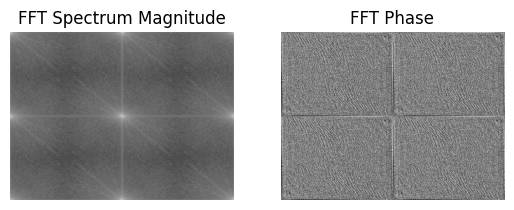

In [ ]:
# Step 2: FFT of the padded image
fft_image = fft2(padded_image)

plt.subplot(2, 2, 1)
plt.imshow(20 * np.log10( 0.01 + np.abs(fftshift(fft_image))), cmap='gray')
plt.title("FFT Spectrum Magnitude")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(np.angle(fftshift(fft_image)), cmap='gray')
plt.title("FFT Phase")
plt.axis('off')
plt.show()


+ fft2(padded_image) tính toán biến đổi Fourier hai chiều (2D FFT) của ma trận padded_image.
    + Sau khi thực hiện phép toán này, các thành phần tần số của ảnh sẽ được chuyển sang miền tần số.
    + Tại miền tần số, các thành phần tần số thấp sẽ tương ứng với các chi tiết lớn trong ảnh, trong khi các thành phần tần số cao sẽ chứa các chi tiết nhỏ hơn và nhiễu.
+ Sau khi áp dụng phép FFT, Có thể thấy các thành phần tần số của ảnh thông qua 2 bức ảnh trên:
    + Magnitude Spectrum: Ảnh này sẽ cho thấy sự phân bố của các thành phần tần số trong ảnh.
    + Phase Spectrum: Ảnh này cho thấy giai đoạn (phase) của các thành phần tần số. Nó chứa thông tin quan trọng về cấu trúc không gian của ảnh.

##### 3.2 LPF (Low-Pass Filter)

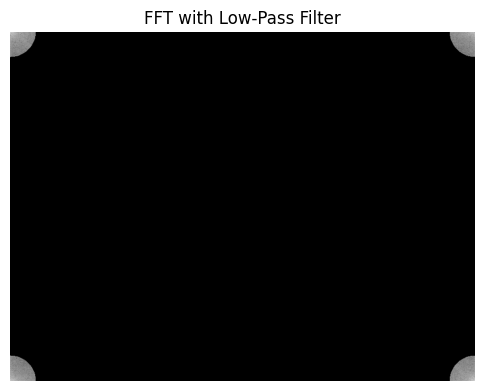

In [20]:
# Step 3: Apply a Low-Pass Filter (LPF)
rows, cols = fft_image.shape
center_row, center_col = rows // 2, cols // 2
radius = 50
mask = np.zeros((rows, cols))

y, x = np.ogrid[:rows, :cols]
mask[(x - center_col) ** 2 + (y - center_row) ** 2 <= radius ** 2] = 1

fft_image_lpf = fft_image * mask

plt.figure(figsize=(6, 6))
plt.imshow(np.log(np.abs(fftshift(fft_image_lpf)) + 1), cmap='gray')
plt.title("FFT with Low-Pass Filter")
plt.axis('off')
plt.show()


+ Khởi tạo biến:
    + rows, cols: số hàng và cột của ảnh.
    + center_row, center_col: Vị trí trung tâm của ảnh trong miền tần số
    + radius: Bán kính của vùng tần số thấp được giữ lại.
+ Tạo mask:
    + mask: Một ma trận ban đầu được khởi tạo với tất cả giá trị là 0, có cùng kích thước với ảnh.
    + y, x = np.ogrid[:rows, :cols]: Tạo hai ma trận con y và x đại diện cho chỉ số hàng và cột của ma trận (cùng kích thước với ảnh).
    + mask[(x - center_col) ** 2 + (y - center_row) ** 2 <= radius ** 2] = 1: Những giá trị trong vùng này được đặt thành 1 (giữ lại), còn các giá trị khác sẽ vẫn là 0 (loại bỏ).
+ Áp dụng mask LPF:
    + fft_image_lpf = fft_image * mask: Nhân ma trận FFT của ảnh với mask LPF. Sau khi nhân, các tần số trong vòng tròn có giá trị 1 (tần số thấp) sẽ được giữ lại, trong khi các tần số bên ngoài (tần số cao) sẽ bị loại bỏ (do mask có giá trị 0).

Sau khi áp dụng FFT cho bức ảnh, Mask LPF sẽ giữ lại các thành phần tần số thấp (gần trung tâm) trong khi loại bỏ các tần số cao (xa trung tâm). Việc làm này sẽ giúp giảm nhiễu và làm mượt ảnh.

##### 3.4 IFFT (Inverse FFT)

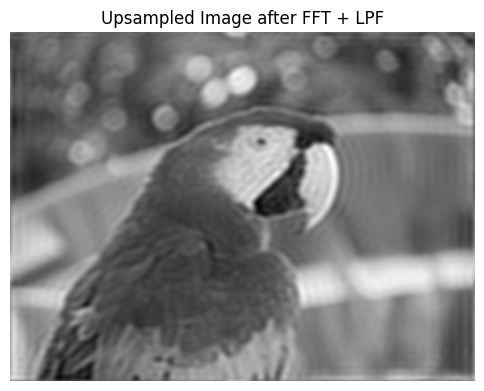

In [21]:
# Step 4: IFFT to get the upsampled image
upsampled_image = np.abs(ifft2(fft_image_lpf))

plt.figure(figsize=(6, 6))
plt.imshow(upsampled_image, cmap='gray')
plt.title("Upsampled Image after FFT + LPF")
plt.axis('off')
plt.show()


+ ifft2(fft_image_lpf): Hàm ifft2 thực hiện Inverse 2D Fast Fourier Transform (IFFT), chuyển ảnh từ miền tần số trở lại miền không gian.
+ np.abs(): Vì IFFT sẽ trả về kết quả là một mảng phức, hàm giá trị tuyệt đối sẽ giúp loại bỏ phần ảo và giữ lại giá trị thực của ảnh sau khi tính IFFT.

Sau khi áp dụng Inverse FFT, đầu ra là một ảnh upsampled_image đã được làm mượt, vì bộ lọc LPF đã loại bỏ các tần số cao (nhiễu, chi tiết nhỏ) trong quá trình tính FFT và IFFT.

#### 4. So sánh ảnh gốc và đã xử lý

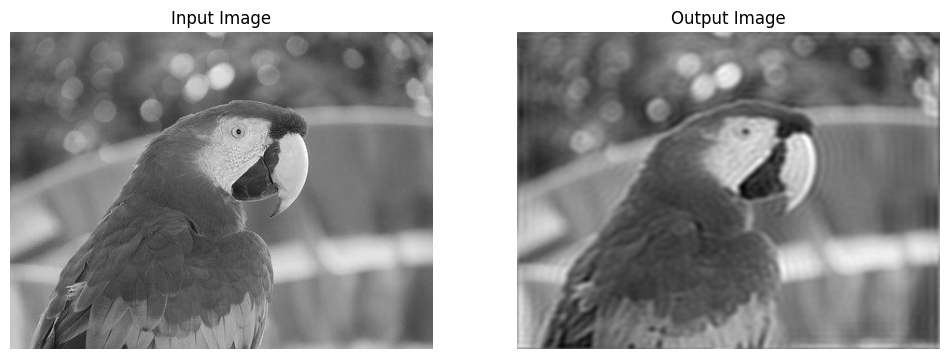

In [22]:
# Compare input and last output
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_np, cmap='gray')
ax[0].set_title("Input Image")
ax[0].axis('off')

ax[1].imshow(upsampled_image, cmap='gray')
ax[1].set_title("Output Image")
ax[1].axis('off')

plt.show()
